To do 
- Eventually optimize to get another DNN architecture?
- Integrate covariance computation into pipeline (instead of pre-processing)
- visualize covariance matrix
- visualize the scatter plots of the n(n+1)/2 covar points for eqch signs.
- Try SVM (like barachant)
- Try Nina's metrics

# 0. Interactive Cloud Version 
(Select GPU/TPU for faster training of the Tensorflow models).

https://colab.research.google.com/github/MariusGuerard/emg_sign_recognition/blob/master/somos_data_analysis.ipynb

In [1]:
import time
a = time.time()

In [2]:
# Set to true to run in colab
RUN_IN_COLAB = False

In [3]:
if RUN_IN_COLAB:
    ### Installing non-colab library.
    !pip install pyriemann
    
    ### Downloading custom libraries (not available with pip)
    !wget https://raw.githubusercontent.com/MariusGuerard/emg_sign_recognition/master/helper_function.py \
        -O /tmp/helper_function.py
    !wget https://raw.githubusercontent.com/MariusGuerard/emg_sign_recognition/master/viz.py \
        -O /tmp/viz.py

    ### Add the tmp directory to the path to be able to import the custom libraries.
    import sys
    sys.path.append('/tmp/')

    ### Downloading and extracting the data
    !wget https://github.com/MariusGuerard/emg_sign_recognition/blob/master/data/data_somos.zip?raw=true\
        -O /tmp/data_somos.zip
    !unzip -o /tmp/data_somos.zip -d /tmp/data_somos/
    # Directory of the data
    data_dir = '/tmp/data_somos/JAN20/'
    
else:
    data_dir = 'data/data_somos/JAN20/'

# Start of the notebook if ran in local

In [4]:
import os, pickle
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from os.path import join
from glob import glob
import time

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
import seaborn as sns
import pandas as pd
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import cross_val_score, train_test_split, cross_validate, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
#from tensorflow.keras import Sequential
tf.__version__

import pyriemann
from pyriemann.tangentspace import TangentSpace

import helper_function as hf
import viz

Using TensorFlow backend.


In [136]:
### Number of splits in the K_Fold (for intra-session only)
N_SPLIT = 3

### Number of hardware acquisitions to consider as a trial.
# The higher the number of steps, the longer the decision time but the better the accuracy.
# With current hardware, the sampling time is 4ms (=250Hz) for all 8 electrodes, so N_STEPS of 100 correspond to trial time (decision time) of 400ms
N_STEPS = 100

### Set to True to load processed data previously saved. 
# Set to False to re-process data with different parameters.
LOAD_DATA = True

### Set to True if you want to use to train the DNN models (which takes way more time than the other algorithms).
TRAIN_DNN = True

# 1. Preliminary comments

In [99]:
# Labels that correspond to the order (0 = Nothing, 1 = Rock, ...)
label_dic = {'Nothing': 0, 'Rock': 1, 'Paper': 2, 'Scissors': 3, 'Ok': 4}

# 2. Loading the Data.

In [100]:
### Functions to read the data in pandas DataFrame with the filenames as values of column 'exp'.
read_somos_csv = lambda path: pd.read_csv(path, sep=',', names = ['time', 'c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'label'], skiprows=1)

def combine_pd(pattern, data_dir=data_dir):
    df = pd.concat([read_somos_csv(x) for x in glob(data_dir + pattern + 'txt')])
    df['exp'] = [pattern] * len(df)
    return df

In [101]:
patterns = ['mg*s1*', 'mg*s2*', 'rr*s1*', 'rr*s2*']

In [102]:
data_df = pd.concat([combine_pd(pattern) for pattern in patterns])

In [103]:
data_df.sample(10)

,time,c0,c1,c2,c3,c4,c5,c6,c7,label,exp
22795,93535,125,136,122,126,131,128,128,128,3,rr*s2*
17898,73485,128,127,126,128,128,130,130,128,2,rr*s2*
5416,22462,128,128,128,127,125,128,127,128,0,rr*s2*
1615,6751,123,127,128,130,126,127,128,126,0,mg*s2*
25373,104319,126,125,136,125,130,129,128,129,4,rr*s2*
9491,38615,128,127,126,124,128,127,128,128,1,rr*s2*
24787,101192,125,128,130,127,128,129,128,128,4,rr*s2*
30449,124999,127,128,130,127,124,124,124,126,4,rr*s2*
16408,67239,127,126,132,128,127,128,129,131,2,mg*s2*
2225,9303,127,127,128,127,126,129,129,128,0,rr*s2*


In [104]:
data_df.describe()

,time,c0,c1,c2,c3,c4,c5,c6,c7,label
count,731682.000000,731682.000000,731682.000000,731682.000000,731682.000000,731682.000000,731682.000000,731682.000000,731682.000000,731682.000000
mean,62558.191848,127.505144,127.507004,127.506409,127.504250,127.505813,127.506537,127.505465,127.503991,2.001328
std,36043.299100,3.565628,4.235870,3.714308,2.794727,2.724745,2.384146,2.779323,2.851516,1.413178
min,4.000000,61.000000,48.000000,27.000000,53.000000,82.000000,54.000000,54.000000,44.000000,0.000000
25%,31345.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,1.000000
50%,62552.000000,128.000000,128.000000,127.000000,127.000000,128.000000,128.000000,128.000000,128.000000,2.000000
75%,93800.750000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,3.000000
max,125014.000000,190.000000,245.000000,193.000000,194.000000,217.000000,210.000000,191.000000,249.000000,4.000000


# 3. Pre-processing of the data

## 3.0 Giving same labels sign map as in Kaggle

In [105]:
labels = data_df.label.values

In [106]:
# Changing the resting state 0 into -1
tmp = np.where(labels==0, -1, labels)
# Changing the Rock 1 in Rock 0
tmp = np.where(tmp==1, 0, tmp)
# Changing the Scissor 3 in Scissors 1
tmp = np.where(tmp==3, 1, tmp)
# Changing the Ok 4 in OK 3
labels = np.where(tmp==4, 3, tmp)

In [107]:
data_df.label = labels

For now let's remove the 'rest' sign (to have a better comparison with the MYO), but we can look at it later.

In [108]:
data_df = data_df[data_df.label != -1]

## 3.1 Batching

The data are being batched by time windows of size 'N_STEPS': (t0_sensor0, ..., t0_sensor8, t1_sensor0, ..., t1_sensor8, ..., tN_STEPS_sensor0, tN_STEPS_sensor8).

In [113]:
### Tagging the start and end of the signs (that allows to not take time window that contains multiple label)
start_sign = np.where(np.diff(data_df.label) != 0)[0]
# We had a margin at the start and the end of the signs to get the stationary signal coresponding to these signs.
end_sign = np.append(start_sign[1:], len(data_df)) - 1000
start_sign += 1000

We have 24 files with 5 signs each (including rest) so we should have 5 * 24 - 1 = 119 changes of sign, or 4 * 24 - 1 = 95 (in case with no rest)

In [114]:
len(start_sign)

95

This step can take a bit of time (~10-60s depending on your computer and your batching parameters)

In [115]:
emg_list = []
label_list = []
exp_list = []
for j in range(len(start_sign)):
    batchs = range(start_sign[j], end_sign[j] - N_STEPS, N_STEPS)
    #print(batchs)
    emg_list.append([data_df.iloc[i: i+N_STEPS, 1: -2].values.flatten() for i in batchs])
    # Similarly to the kaggle data let's create samples of 10 time steps of 8 channel: t0_sensor0, t0_sensor1, ..., t10_sensor0, ..., t10_sensor8.
    label_list.append([data_df.iloc[i, -2] for i in batchs])
    # Similarly to the kaggle data let's create samples of 10 time steps of 8 channel: t0_sensor0, t0_sensor1, ..., t10_sensor0, ..., t10_sensor8.
    exp_list.append([data_df.iloc[i, -1] for i in batchs])
emg = np.concatenate(emg_list)
labels = np.hstack(label_list)
exps = np.hstack(exp_list)

Our EMG matrix should now have the shape (~len(raw)/N_STEPS, N_ELEC * N_STEPS) 

In [116]:
emg.shape

(3856, 800)

### 3.2 Separation in 4 datasets (2 sessions for 2 users)

In [119]:
# Save the data pre-processed in a pickle to go faster at next execution 
# (You need to set LOAD_DATA to False if some parameters relative to this data needs to be modified).
if 'data_batched.pickle' in os.listdir() and LOAD_DATA:
    with open('data_batched.pickle', 'rb') as handle:
        data_per_exp = pickle.load(handle)
else:
    data_per_exp = {}
    for exp_name in patterns:
        idx_exp = np.where(exps==exp_name)[0]
        data_per_exp[exp_name] = {'raw': np.float_(emg[idx_exp]), 'labels': labels[idx_exp]}
        print(len(emg[idx_exp]))
    with open('data_batched.pickle', 'wb') as handle:
        pickle.dump(data_per_exp, handle)

931
978
973
974


# 4. Model on each dataset separately

In this section, we are just using each dataset separately to both fit and evaluate different models. That gives an idea of the best-case scenario (when the user tries the wrist band just after having calibrating it)

In [120]:
# Dictionary containing all accuracy and models for the intra-session experiment.
result_intra = {}

In [121]:
# For the intra-session experiment, we split the dataset into N_SPLIT stratified Kfold for better test accuracy estimation.
k_fold = StratifiedKFold(n_splits=N_SPLIT, shuffle=True, random_state=7)

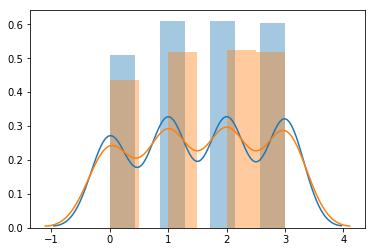

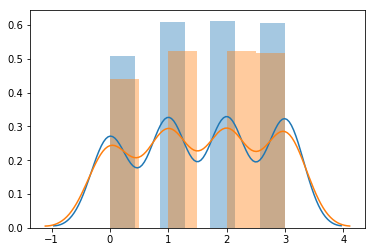

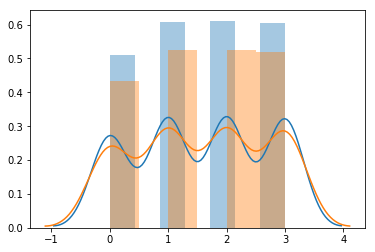

In [122]:
### Let's plot the distribution of the labels for the train set and the validation test of each Fold of one experiment.
X = data_per_exp['mg*s1*']['raw']
y = data_per_exp['mg*s1*']['labels']
for train_indices, test_indices in k_fold.split(X, y):
    plt.figure()
    sns.distplot(y[train_indices])
    sns.distplot(y[test_indices])

The plots above confirm that the 4 signs are equally represented in our 3 splits (as we used a stratified KFold).

## 4.1 Using the Row Data

This is if we were to use the models directly on the N_channels x N_time_steps features of a sample. Here it is very important to scale the data, as the signal sent from the FPGA has a very big biais relatively to the signal energy, and as the biais can be different for each electrodes.

### 4.1.0 Naive Model

This random model is used to see what accuracy we would get by guessing randomly what sample corresponds to what sign. In average, we should have 25% accuracy if we have 4 signs and 20% accuracy if we have 5 signs.

In [123]:
class ChanceDetector():
    """Just a random number generator.
    """
    def __init__(self, n_class):
        self.n_class = 4

    def fit(self, X_train, y_train):
        return None
    
    def predict(self, X_test):
        lx = len(X_test)
        return np.random.randint(0, self.n_class, lx)

In [124]:
### Scikit-learn pipeline combining a standard scaler and our model.
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('naive',  ChanceDetector(4)))
pipeline_naive = Pipeline(estimators)

In [128]:
### Fit and Test our model on the k_fold and store the results in result_intra.
result_intra = hf.record_results_kfold(data_per_exp, result_intra, model=pipeline_naive, kfold=k_fold, key_result='naive_raw', key_data='raw')

mg*s1* [0.2532051282051282, 0.19032258064516128, 0.22006472491909385] 0.22119747792312774
mg*s2* [0.24695121951219512, 0.24307692307692308, 0.24615384615384617] 0.2453939962476548
rr*s1* [0.254601226993865, 0.2654320987654321, 0.2693498452012384] 0.26312772365351184
rr*s2* [0.2392638036809816, 0.24074074074074073, 0.25925925925925924] 0.2464212678936605


As expected we have scores around 25% using the naive model on each dataset.

### 4.1.1 With Logistic Regression

In [126]:
### Scikit-learn pipeline combining a standard scaler and our model.
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('lr', LogisticRegression(solver='lbfgs', multi_class='multinomial')))
pipeline_lr = Pipeline(estimators)

In [129]:
### Fit and Test our model on the k_fold and store the results in result_intra.
result_intra = hf.record_results_kfold(data_per_exp, result_intra, model=pipeline_lr, kfold=k_fold, key_result='lr_raw', key_data='raw')

mg*s1* [0.25961538461538464, 0.26129032258064516, 0.2168284789644013] 0.24591139538681037
mg*s2* [0.25609756097560976, 0.28615384615384615, 0.2523076923076923] 0.2648530331457161
rr*s1* [0.27607361963190186, 0.24691358024691357, 0.25386996904024767] 0.2589523896396877
rr*s2* [0.25153374233128833, 0.29012345679012347, 0.2808641975308642] 0.27417379888409205


Barely above chance level

### 4.1.2. With Deep Neural Net (DNN)

In [131]:
def create_model(weights='initial_weights.hd5', n_features=800):
    """Function to create model, required for using KerasClassifier and wrapp a Keras model inside a 
    scikitlearn form.
    We added a weight saving/loading to remove the randomness of the weight initialization (for better comparison).
    """
    model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(34, activation='relu', input_shape=(n_features,)),
    tf.keras.layers.Dense(17, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4, activation='softmax'),
])
    
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    if weights is None:
        model.save_weights('initial_weights.hd5')
    else:
        model.load_weights(weights)
    return model

In [132]:
generate_weights = create_model(weights=None)

In [133]:
### Scikit-learn pipeline combining a standard scaler and our model.
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('dnn', KerasClassifier(build_fn=create_model, epochs=100, verbose=0)))
pipeline_dnn = Pipeline(estimators)

In [134]:
### Fit and Test our model on the k_fold and store the results in result_intra.
# This training can take a bit of time.
if TRAIN_DNN:
    result_intra = hf.record_results_kfold(data_per_exp, result_intra, model=pipeline_dnn, kfold=k_fold, key_result='dnn_raw', key_data='raw')

mg*s1* [0.2692307692307692, 0.2870967741935484, 0.2815533980582524] 0.27929364716085664
mg*s2* [0.25, 0.28615384615384615, 0.2923076923076923] 0.2761538461538462
rr*s1* [0.2822085889570552, 0.33641975308641975, 0.3065015479876161] 0.3083766300103637
rr*s2* [0.3067484662576687, 0.27469135802469136, 0.33024691358024694] 0.3038955792875357


## 4.2 Using Covariances

Just as for EEG, most of the information should be contains in the covariance matrix of each sample.
For 8 channels and N_STEPS time steps samples, this matrix will have dimension 8x8

In [37]:
i = start_sign[0]
data_df.iloc[i: i+10]

,time,c0,c1,c2,c3,c4,c5,c6,c7,label,exp
13206,54156,123,127,127,128,127,128,127,127,2,mg*s1*
13207,54159,127,129,126,126,127,127,128,128,2,mg*s1*
13208,54162,132,124,123,126,128,127,129,123,2,mg*s1*
13209,54166,129,131,131,126,127,128,130,119,2,mg*s1*
13210,54169,124,130,130,136,124,128,134,123,2,mg*s1*
13211,54172,126,131,129,121,128,130,128,134,2,mg*s1*
13212,54176,131,131,127,125,127,131,121,135,2,mg*s1*
13213,54178,125,130,132,122,128,128,127,130,2,mg*s1*
13214,54181,124,128,130,122,128,131,130,126,2,mg*s1*
13215,54185,129,127,123,125,129,129,131,131,2,mg*s1*


In [137]:
# Save the data pre-processed with covariance in a pickle to go faster at next execution 
# (You need to set LOAD_DATA to False if some parameters relative to this data needs to be modified).
if 'cov.pickle' in os.listdir() and LOAD_DATA:
    with open('cov.pickle', 'rb') as handle:
        data_per_exp = pickle.load(handle)
else:
    for key, data in data_per_exp.items():
        # X: your EEG data, in format Ntrials x Nchannels X Nsamples
        emg_rows = data['raw']
        X = np.array([x.reshape(N_STEPS, 8).transpose() for x in emg_rows])
        # Covariance Matrix with Ledoit and Wolf Regularization (https://projecteuclid.org/euclid.aos/1342625460)
        cov = pyriemann.estimation.Covariances(estimator='lwf').fit_transform(X)
        # Computation of the vectorized matrix to used each elements as features (without Tangeant Space Projection).
        covec = np.array([hf.vectorize_cov(cov_mat) for cov_mat in cov])
        # The variance correspond to the diagonal elements of the covariance.
        var = np.array([cov_mat.diagonal() for cov_mat in cov])
        y = data['labels']
        data['matrix'] = X
        data['cov'] = cov
        data['covec'] = covec
        data['var'] = var
    with open('cov.pickle', 'wb') as handle:
        pickle.dump(data_per_exp, handle)

In [138]:
data_per_exp['mg*s1*']['matrix'].shape

(931, 8, 100)

In [139]:
data_per_exp['mg*s1*']['var'].shape

(931, 8)

In [140]:
data_per_exp['mg*s1*']['covec'].shape

(931, 36)

In [141]:
data_per_exp['mg*s1*']['cov'].shape

(931, 8, 8)

### 4.2.1 Logistic Regression on Variance

We first look only at the variance (or the energy of each electrodes'signal), that corresponds to the diagonal of the covariance.

In [142]:
### Scikit-learn pipeline combining a standard scaler and our model.
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('lr', LogisticRegression(solver='lbfgs', multi_class='multinomial')))
pipeline_lr = Pipeline(estimators)

In [143]:
### Fit and Test our model on the k_fold and store the results in result_intra.
result_intra = hf.record_results_kfold(data_per_exp, result_intra, model=pipeline_lr, kfold=k_fold, key_result='logreg_var', key_data='var')

mg*s1* [0.967948717948718, 0.9838709677419355, 0.9676375404530745] 0.9731524087145761
mg*s2* [0.9847560975609756, 0.9723076923076923, 0.9692307692307692] 0.9754315196998125
rr*s1* [0.9846625766871165, 0.9907407407407407, 0.9845201238390093] 0.9866411470889555
rr*s2* [0.9846625766871165, 0.9660493827160493, 0.9537037037037037] 0.9681385543689566


Way better results than everything else we tried so far! 
For this experiment with not much class, and only static signs, most of the discriminative information is contained in the variance.

### 4.2.2 DNN on Variance

In [144]:
def create_model_variance(weights='initial_weights.hd5'):
    return create_model(weights=weights, n_features=8)

In [145]:
generate_weights = create_model_variance(weights=None)

In [146]:
### Scikit-learn pipeline combining a standard scaler and our model.
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('dnn', KerasClassifier(build_fn=create_model_variance, epochs=100, verbose=0)))
pipeline_dnn = Pipeline(estimators)

In [147]:
### Fit and Test our model on the k_fold and store the results in result_intra.
if TRAIN_DNN:
    result_intra = hf.record_results_kfold(data_per_exp, result_intra, model=pipeline_dnn, kfold=k_fold, key_result='dnn_var', key_data='var')

mg*s1* [0.9935897435897436, 0.9935483870967742, 0.9741100323624595] 0.9870827210163258
mg*s2* [0.9908536585365854, 0.9876923076923076, 0.9938461538461538] 0.9907973733583489
rr*s1* [0.99079754601227, 0.9876543209876543, 0.9938080495356038] 0.9907533055118427
rr*s2* [0.9754601226993865, 0.9783950617283951, 0.9629629629629629] 0.9722727157969149


Let's try to add all covariances elements to see if we gain in accuracy.

### 4.2.3 Log Reg on covariance Matrix

Let's now look if adding the non-diagonal elements of the covariance matrix can help to gain in accuracy.

In [149]:
### Scikit-learn pipeline combining a standard scaler and our model.
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('lr', LogisticRegression(solver='lbfgs', multi_class='multinomial')))
pipeline_logreg = Pipeline(estimators)

In [150]:
### Fit and Test our model on the k_fold and store the results in result_intra.
result_intra = hf.record_results_kfold(data_per_exp, result_intra, model=pipeline_logreg, kfold=k_fold, key_result='logreg_covec', key_data='covec')

mg*s1* [0.9743589743589743, 0.9806451612903225, 0.970873786407767] 0.975292640685688
mg*s2* [0.9664634146341463, 0.9569230769230769, 0.9323076923076923] 0.9518980612883051
rr*s1* [0.9846625766871165, 0.9876543209876543, 0.978328173374613] 0.9835483570164613
rr*s2* [0.9846625766871165, 0.9629629629629629, 0.9475308641975309] 0.9650521346158701


### 4.2.4 DNN on covariance Matrix

In [151]:
def create_model_covariance(weights='initial_weights.hd5'):
    return create_model(weights=weights, n_features=36)
generate_weights = create_model_covariance(weights=None)

In [152]:
### Scikit-learn pipeline combining a standard scaler and our model.
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('dnn', KerasClassifier(build_fn=create_model_covariance, epochs=100, verbose=0)))
pipeline_dnn = Pipeline(estimators)

In [154]:
### Fit and Test our model on the k_fold and store the results in result_intra.
if TRAIN_DNN:
    result_intra = hf.record_results_kfold(data_per_exp, result_intra, model=pipeline_dnn, kfold=k_fold, key_result='dnn_covec', key_data='covec')

mg*s1* [0.9871794871794872, 0.9870967741935484, 0.9805825242718447] 0.9849529285482935
mg*s2* [0.9786585365853658, 0.9692307692307692, 0.963076923076923] 0.970322076297686
rr*s1* [0.9846625766871165, 0.9938271604938271, 0.9752321981424149] 0.9845739784411195
rr*s2* [0.9723926380368099, 0.9475308641975309, 0.9567901234567902] 0.9589045418970435


(I also ran it with unscaled data and it doesn't seem to change much here as the covariance are already scaled)

### 4.2.5 Euclidean Minimum Distance to Mean (Eucl MDM)

Now let's try to look at simpler algorithm (that might have bigger biais but potentially less variance as they have less parameters). We first look at the MDM in Euclidean geometry. For which we should be able to use covec or cov indifferently.

With Scaling.

In [186]:
### Scikit-learn pipeline combining a standard scaler and our model.
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('MDM', hf.ClosestMean()))
pipeline_MDM = Pipeline(estimators)

In [187]:
result_intra = hf.record_results_kfold(data_per_exp, result_intra, model=pipeline_MDM, kfold=k_fold, key_result='eucl_mdm_covec', key_data='covec')

mg*s1* [0.8141025641025641, 0.8032258064516129, 0.7831715210355987] 0.8001666305299252
mg*s2* [0.774390243902439, 0.8307692307692308, 0.7753846153846153] 0.7935146966854285
rr*s1* [0.7515337423312883, 0.7777777777777778, 0.7554179566563467] 0.7615764922551377
rr*s2* [0.9049079754601227, 0.8672839506172839, 0.9074074074074074] 0.8931997778282713


Without Scaling.

In [183]:
result_intra = hf.record_results_kfold(data_per_exp, result_intra, model=hf.ClosestMean(), kfold=k_fold, key_result='eucl_mdm_covec', key_data='covec')

mg*s1* [0.9006410256410257, 0.8838709677419355, 0.8511326860841424] 0.8785482264890345
mg*s2* [0.8536585365853658, 0.8523076923076923, 0.8061538461538461] 0.8373733583489681
rr*s1* [0.8220858895705522, 0.8580246913580247, 0.8111455108359134] 0.8304186972548301
rr*s2* [0.852760736196319, 0.8549382716049383, 0.8055555555555556] 0.8377515211189376


### 4.2.6 Riemannian MDM 

The covariance matrix are SPD matrix and the distance between SPD matrix can be measured with Riemanian metrics that have nice properties.
(See for example how it is applied to EEG signal in https://hal.archives-ouvertes.fr/hal-01570120/document)

Without Scaling.

In [160]:
result_intra = hf.record_results_kfold(data_per_exp, result_intra, model=pyriemann.classification.MDM(), kfold=k_fold, key_result='riemann_mdm_cov', key_data='cov')

mg*s1* [0.9358974358974359, 0.9032258064516129, 0.883495145631068] 0.9075394626600389
mg*s2* [0.9359756097560976, 0.9446153846153846, 0.9353846153846154] 0.9386585365853658
rr*s1* [0.9386503067484663, 0.9228395061728395, 0.9256965944272446] 0.9290621357828502
rr*s2* [0.9386503067484663, 0.9197530864197531, 0.9104938271604939] 0.9229657401095711


### 4.2.7 Tangeant Space + Log Reg

Another use of the Riemannian geometry is to project the covariance matrix on a tangeant space that is euclidean and on which we can apply usual machine learning algorithms. You can think of the projection as the translation of a sphere into a plan (like in the case of world maps).

In [164]:
### Scikit-learn pipeline combining a standard scaler and our model.
estimators = []
estimators.append(('ts', TangentSpace()))
estimators.append(('lr', LogisticRegression(solver='lbfgs', multi_class='multinomial')))
pipeline_tang_lr = Pipeline(estimators)

In [165]:
result_intra = hf.record_results_kfold(data_per_exp, result_intra, model=pipeline_tang_lr, kfold=k_fold, key_result='ts_logreg_cov', key_data='cov')

mg*s1* [0.9871794871794872, 0.9935483870967742, 0.9838187702265372] 0.9881822148342662
mg*s2* [0.9786585365853658, 0.9723076923076923, 0.9784615384615385] 0.9764759224515321
rr*s1* [0.9938650306748467, 0.9938271604938271, 0.9969040247678018] 0.9948654053121585
rr*s2* [0.9846625766871165, 0.9753086419753086, 0.9722222222222222] 0.9773978136282158


### 4.2.8 Tangeant Space + DNN

In [166]:
# Function to create model, required for KerasClassifier
def create_model_covariance(weights='initial_weights.hd5'):
    return create_model(weights=weights, n_features=36)
generate_weights = create_model_covariance(weights=None)

In [167]:
estimators = []
#estimators.append(('standardize', StandardScaler()))
estimators.append(('ts', TangentSpace()))
estimators.append(('dnn', KerasClassifier(build_fn=create_model_covariance, epochs=100, verbose=0)))
pipeline_tang_dnn = Pipeline(estimators)

In [169]:
if TRAIN_DNN:
    result_intra = hf.record_results_kfold(data_per_exp, result_intra, model=pipeline_tang_dnn, kfold=k_fold, key_result='ts_dnn_cov', key_data='cov')

mg*s1* [0.9967948717948718, 1.0, 0.9870550161812298] 0.9946166293253672
mg*s2* [0.9908536585365854, 0.9846153846153847, 0.9876923076923076] 0.9877204502814259
rr*s1* [0.99079754601227, 0.9969135802469136, 0.9907120743034056] 0.992807733520863
rr*s2* [0.9938650306748467, 0.9876543209876543, 0.9845679012345679] 0.9886957509656896


## 4.3 Plotting intra-sessions results

In [188]:
acc_vec = np.array([acc_model['acc_all'] for key, acc_model in result_intra.items()]).transpose()
model_labels = result_intra.keys()

KeyError: 'acc_all'

ValueError: shape mismatch: objects cannot be broadcast to a single shape

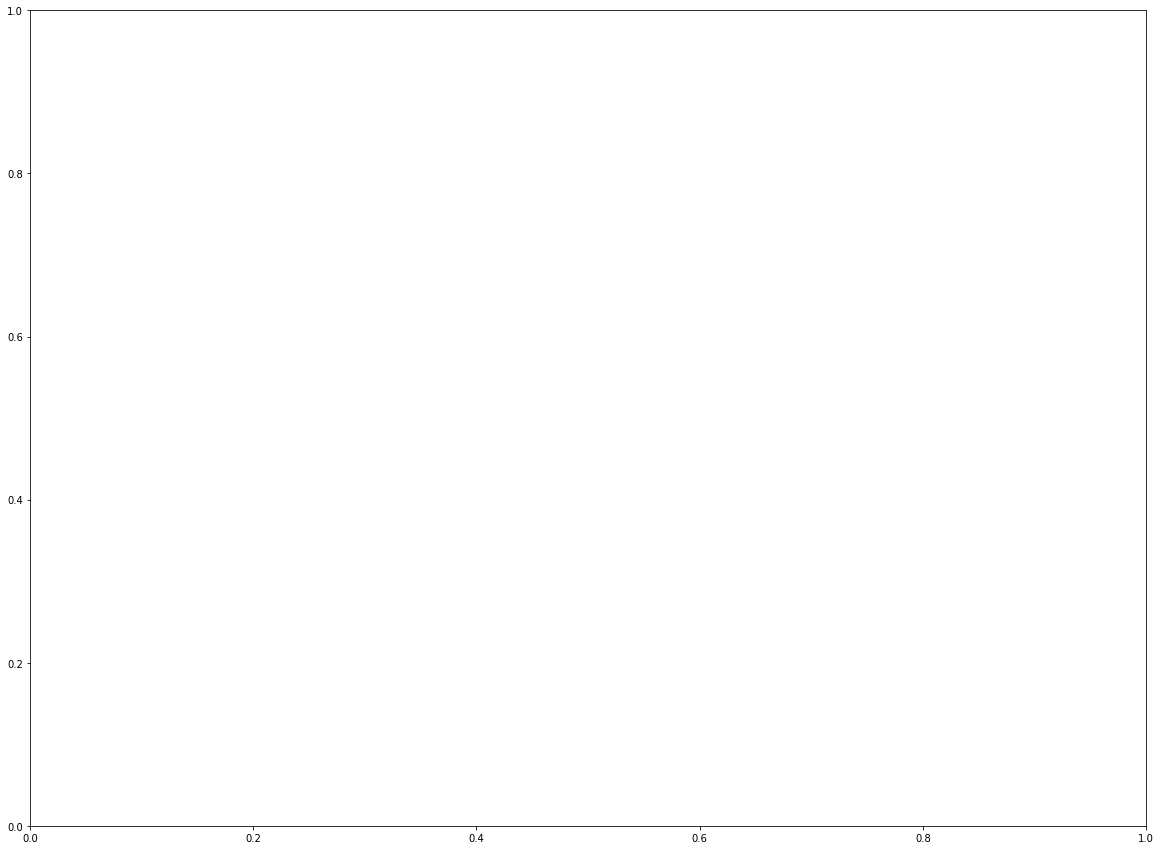

In [189]:
viz.bar_plot_scatter_comp([acc_vec], model_labels, 'intra-session', ['acc'])

We notice that most of the information of the signal seem to be contained in the covariance matrix of the electrodes (and particularly in its diagonal: the variances)

In [67]:
acc_var = np.array([acc_model['acc_all'] for key, acc_model in result_intra.items() if 'raw' not in key]).transpose()
model_labels = [x for x in result_intra.keys() if 'raw' not in x]

(0.7, 1.1)

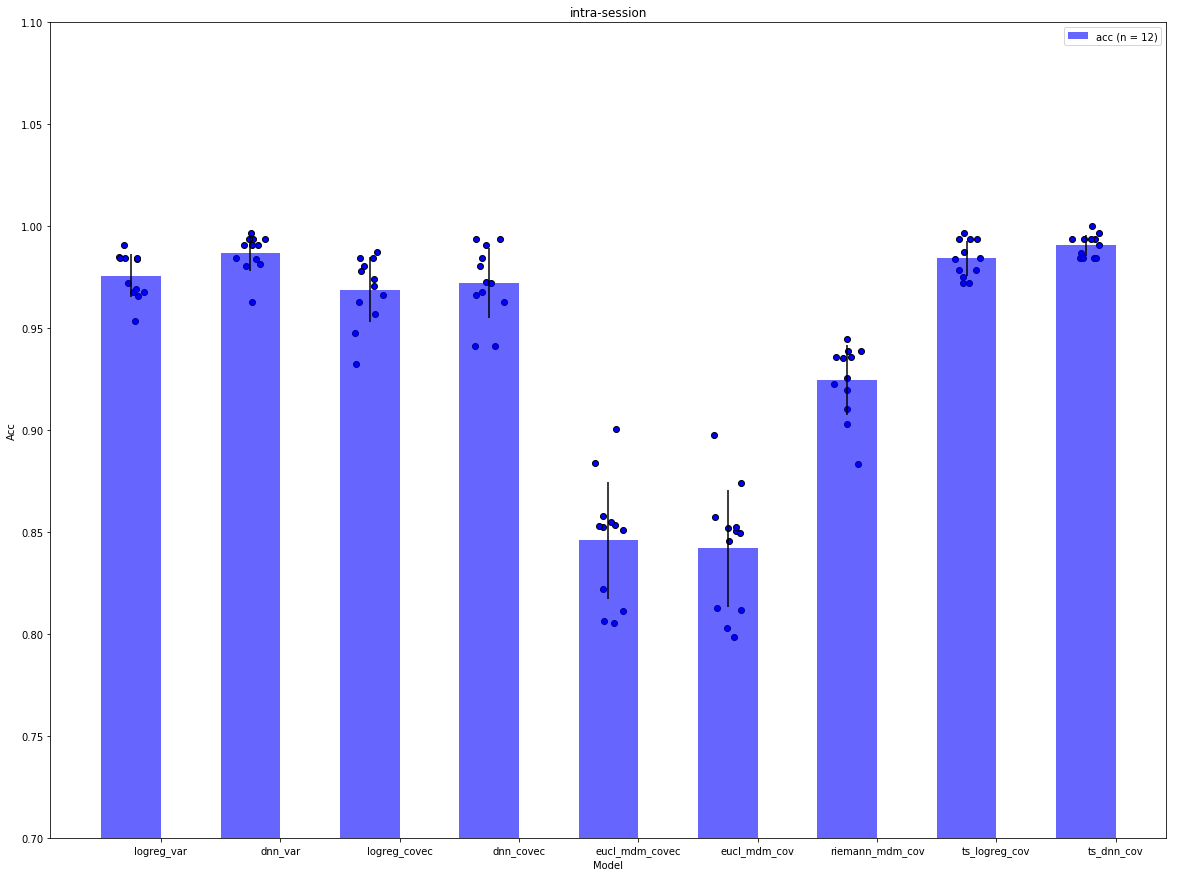

In [68]:
viz.bar_plot_scatter_comp([acc_var], model_labels, 'intra-session', ['acc'])
plt.ylim([0.7, 1.1])

Depending on the value you chose for N_STEPS, you may or may not see a big difference between this algorithms but you should observe a this kind of trend (at least with N_STEPS = 100):
- At least with these models training on raw data is completely inefficient (might works better with RNN, but might also probably overfit between sessions...)
- For very simple models (MDM), Riemannian framework gives better result that the usual euclidean geometry.
- For standard models (logreg, DNN), the accuracy is similar with slightly better results for model using tangeant space.

# 5. Model on Inter-session

Here we train model on one session, and then test this model on another session, after the user removed and repositioned the armband. This is to evaluate what kind of performance we could get without having to recalibrate the device everytime the users are removing it.

## 5.1 Euclidean MDM

In [171]:
### This dictionary will contain the results for the inter-session experiments
result_intersess = {}

With Scaling.

In [178]:
### Scikit-learn pipeline combining a standard scaler and our model.
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('MDM', hf.ClosestMean()))
pipeline_MDM = Pipeline(estimators)

In [179]:
result_intersess = hf.train_test_intersession(data_per_exp, result_intersess, pipeline_MDM, key_result='eucl_mdm', data_type='covec')

mg*s1* mg*s2* 0.5838445807770961
mg*s2* mg*s1* 0.5746509129967776
rr*s1* rr*s2* 0.5277207392197125
rr*s2* rr*s1* 0.5950668036998972
avg: 0.5703207591733708


Without Scaling.

In [180]:
result_intersess = hf.train_test_intersession(data_per_exp, result_intersess, hf.ClosestMean(), key_result='eucl_mdm', data_type='covec')

mg*s1* mg*s2* 0.6492842535787321
mg*s2* mg*s1* 0.7389903329752954
rr*s1* rr*s2* 0.5277207392197125
rr*s2* rr*s1* 0.8047276464542652
avg: 0.6801807430570013


## 5.2 Riemann MDM

In [190]:
result_intersess = hf.train_test_intersession(data_per_exp, result_intersess, pyriemann.classification.MDM(), key_result='riemann_mdm', data_type='cov')

mg*s1* mg*s2* 0.6339468302658486
mg*s2* mg*s1* 0.44575725026852847
rr*s1* rr*s2* 0.6837782340862423
rr*s2* rr*s1* 0.7841726618705036
avg: 0.6369137441227808


## 5.3 Log Reg on cov

In [191]:
result_intersess = hf.train_test_intersession(data_per_exp, result_intersess, LogisticRegression(solver='lbfgs', multi_class='multinomial'), key_result='logrec_covec', data_type='covec')

/home/marius/miniconda3/envs/stats/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/marius/miniconda3/envs/stats/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/marius/miniconda3/envs/stats/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


mg*s1* mg*s2* 0.7157464212678937
mg*s2* mg*s1* 0.4189044038668099
rr*s1* rr*s2* 0.7053388090349076
rr*s2* rr*s1* 0.7821171634121274
avg: 0.6555266993954346


/home/marius/miniconda3/envs/stats/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


## 5.4 Tangeant + Log Reg

In [192]:
estimators = []
estimators.append(('ts', TangentSpace()))
estimators.append(('lr', LogisticRegression(solver='lbfgs', multi_class='multinomial')))
pipeline_tang_lr = Pipeline(estimators)

In [193]:
result_intersess = hf.train_test_intersession(data_per_exp, result_intersess, pipeline_tang_lr, key_result='ts_logrec_cov', data_type='cov')

mg*s1* mg*s2* 0.7310838445807771
mg*s2* mg*s1* 0.5875402792696026
rr*s1* rr*s2* 0.6930184804928131
rr*s2* rr*s1* 0.9044193216855088
avg: 0.7290154815071754


## 5.5 DNN on Cov

In [194]:
# Function to create model, required for KerasClassifier
def create_model_covariance(weights='initial_weights.hd5'):
    return create_model(weights=weights, n_features=36)
generate_weights = create_model_covariance(weights=None)

In [195]:
estimators = []
#estimators.append(('standardize', StandardScaler()))
estimators.append(('ts', TangentSpace()))
estimators.append(('dnn', KerasClassifier(build_fn=create_model_covariance, epochs=100, verbose=0)))
pipeline_tang_dnn = Pipeline(estimators)

In [197]:
if TRAIN_DNN:
    result_intersess = hf.train_test_intersession(data_per_exp, result_intersess, pipeline_tang_dnn, key_result='ts_dnn_cov', data_type='cov')

mg*s1* mg*s2* 0.7269938650306749
mg*s2* mg*s1* 0.5295381310418904
rr*s1* rr*s2* 0.7751540041067762
rr*s2* rr*s1* 0.9023638232271326
avg: 0.7335124558516185


## 5.6 Tangeant + DNN

In [198]:
def create_model_covariance(weights='initial_weights.hd5'):
    return create_model(weights=weights, n_features=36)
generate_weights = create_model_covariance(weights=None)

In [199]:
if TRAIN_DNN:
    result_intersess = hf.train_test_intersession(data_per_exp, result_intersess, KerasClassifier(build_fn=create_model_covariance, epochs=100, verbose=0), key_result='dnn_covec', data_type='covec')

mg*s1* mg*s2* 0.7269938650306749
mg*s2* mg*s1* 0.5359828141783028
rr*s1* rr*s2* 0.7166324435318275
rr*s2* rr*s1* 0.8674203494347379
avg: 0.7117573680438858


In [200]:
acc_inter = np.array([list(model['acc'].values()) for key, model in result_intersess.items()]).transpose()[0]
model_labels = [x for x in result_intersess.keys()]

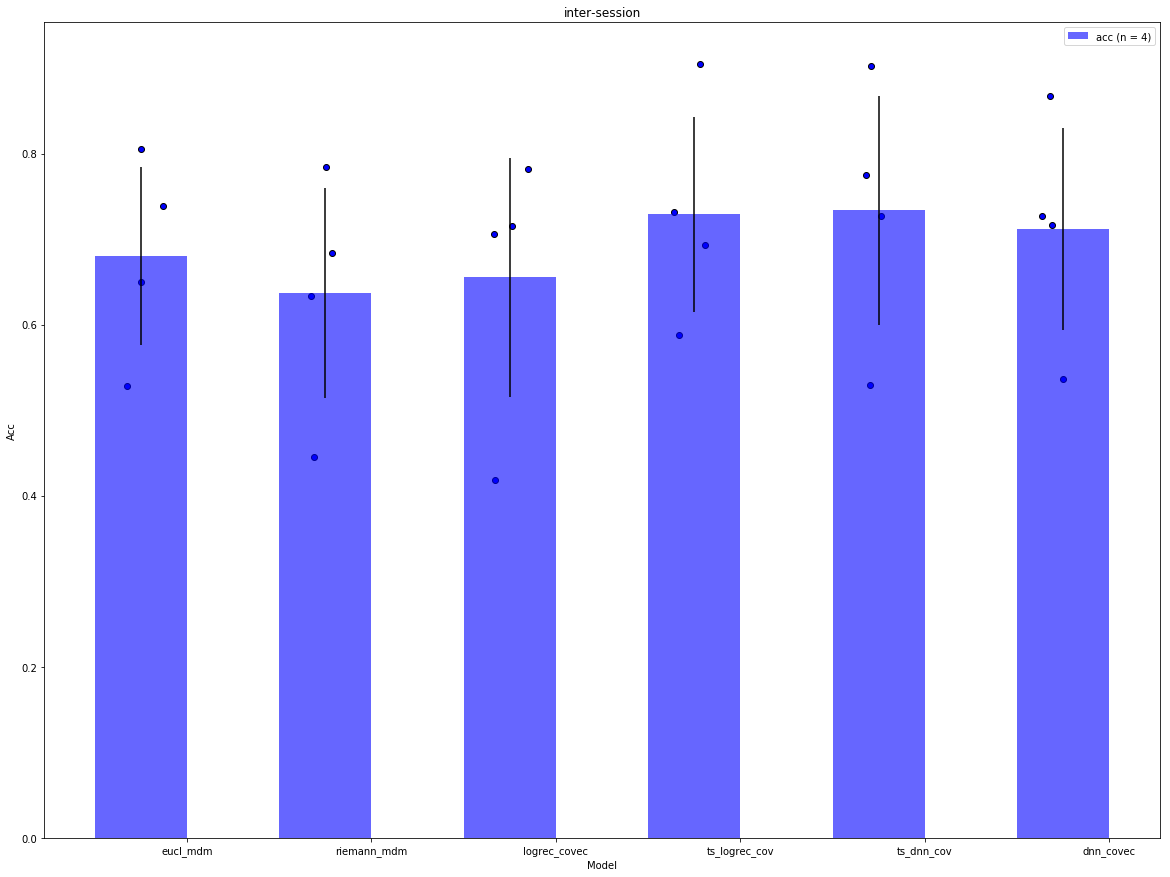

In [201]:
viz.bar_plot_scatter_comp([acc_inter], model_labels, 'inter-session', ['acc'])
#plt.ylim([0.7, 1.1])

# 6. Model on Inter-subjects

In [82]:
result_subj = {}

## 6.1 Euclidean MDM

In [83]:
result_subj = hf.train_test_intersubjects(data_per_exp, result_subj, hf.ClosestMean(), key_result='mdm_eucl')

mg*s1* rr*s1* 0.25488180883864336
mg*s1* rr*s2* 0.2587268993839836
mg*s2* rr*s1* 0.26618705035971224
mg*s2* rr*s2* 0.27618069815195073
rr*s1* mg*s1* 0.2964554242749731
rr*s1* mg*s2* 0.49897750511247446
rr*s2* mg*s1* 0.4414607948442535
rr*s2* mg*s2* 0.6175869120654397
avg: 0.36380713662892883


## 6.2 Riemann MDM

In [84]:
result_subj = hf.train_test_intersubjects(data_per_exp, result_subj, pyriemann.classification.MDM(), key_result='mdm_riemann')

mg*s1* rr*s1* 0.23741007194244604
mg*s1* rr*s2* 0.25770020533880905
mg*s2* rr*s1* 0.3823227132579651
mg*s2* rr*s2* 0.41683778234086244
rr*s1* mg*s1* 0.2953813104189044
rr*s1* mg*s2* 0.4233128834355828
rr*s2* mg*s1* 0.21267454350161116
rr*s2* mg*s2* 0.5184049079754601
avg: 0.34300555227645513


## 6.3 Log Reg on cov

In [85]:
result_subj = hf.train_test_intersubjects(data_per_exp, result_subj, LogisticRegression(solver='lbfgs', multi_class='multinomial'), key_result='log_covec', data_type='covec')

mg*s1* rr*s1* 0.4244604316546763
mg*s1* rr*s2* 0.6416837782340863
mg*s2* rr*s1* 0.3175745118191161
mg*s2* rr*s2* 0.3028747433264887


/home/marius/miniconda3/envs/stats/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/marius/miniconda3/envs/stats/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/marius/miniconda3/envs/stats/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/marius/miniconda3/envs/stats/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


rr*s1* mg*s1* 0.40494092373791624
rr*s1* mg*s2* 0.591002044989775
rr*s2* mg*s1* 0.47261009667024706
rr*s2* mg*s2* 0.6738241308793456
avg: 0.47862133266395646


## 6.4 Tangeant + Log Reg

In [86]:
estimators = []
estimators.append(('ts', TangentSpace()))
estimators.append(('lr', LogisticRegression(solver='lbfgs', multi_class='multinomial')))
pipeline_tang_lr = Pipeline(estimators)

In [87]:
result_subj = hf.train_test_intersubjects(data_per_exp, result_subj, pipeline_tang_lr, key_result='ts_log')

mg*s1* rr*s1* 0.17163412127440905
mg*s1* rr*s2* 0.25051334702258726
mg*s2* rr*s1* 0.24049331963001028
mg*s2* rr*s2* 0.2515400410677618
rr*s1* mg*s1* 0.2900107411385607
rr*s1* mg*s2* 0.7280163599182005
rr*s2* mg*s1* 0.4296455424274973
rr*s2* mg*s2* 0.6789366053169734
avg: 0.3800987597245


## 6.5 DNN on Cov

In [88]:
# Function to create model, required for KerasClassifier
def create_model(weights='initial_weights.hd5'):
    # Create model.
    model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(34, activation='relu', input_shape=(36,)),
    tf.keras.layers.Dense(17, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4, activation='softmax'),
])
    # Compile model
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    if weights is None:
        model.save_weights('initial_weights.hd5')
    else:
        model.load_weights(weights)
    return model

In [89]:
generate_weights = create_model(weights=None)

In [90]:
result_subj = hf.train_test_intersubjects(data_per_exp, result_subj, KerasClassifier(build_fn=create_model, epochs=100, verbose=0), key_result='dnn_covec', data_type='covec')

mg*s1* rr*s1* 0.3052415210688592
mg*s1* rr*s2* 0.6293634496919918
mg*s2* rr*s1* 0.30832476875642345
mg*s2* rr*s2* 0.2936344969199179
rr*s1* mg*s1* 0.3619763694951665
rr*s1* mg*s2* 0.6104294478527608
rr*s2* mg*s1* 0.42105263157894735
rr*s2* mg*s2* 0.6247443762781186
avg: 0.4443458827052732


## 6.6 Tangeant + DNN

In [91]:
estimators = []
#estimators.append(('standardize', StandardScaler()))
estimators.append(('ts', TangentSpace()))
estimators.append(('dnn', KerasClassifier(build_fn=create_model, epochs=100, verbose=0)))
pipeline_tang_dnn = Pipeline(estimators)

In [92]:
result_subj = hf.train_test_intersubjects(data_per_exp, result_subj, pipeline_tang_dnn, key_result='ts_dnn')

mg*s1* rr*s1* 0.4234326824254882
mg*s1* rr*s2* 0.3675564681724846
mg*s2* rr*s1* 0.29804727646454265
mg*s2* rr*s2* 0.2618069815195072
rr*s1* mg*s1* 0.3501611170784103
rr*s1* mg*s2* 0.7208588957055214
rr*s2* mg*s1* 0.40064446831364126
rr*s2* mg*s2* 0.7075664621676891
avg: 0.44125929398091057


# Plotting

In [93]:
acc_subj = np.array([model['acc'] for key, model in result_subj.items()]).transpose()
model_labels = [x for x in result_subj.keys()]

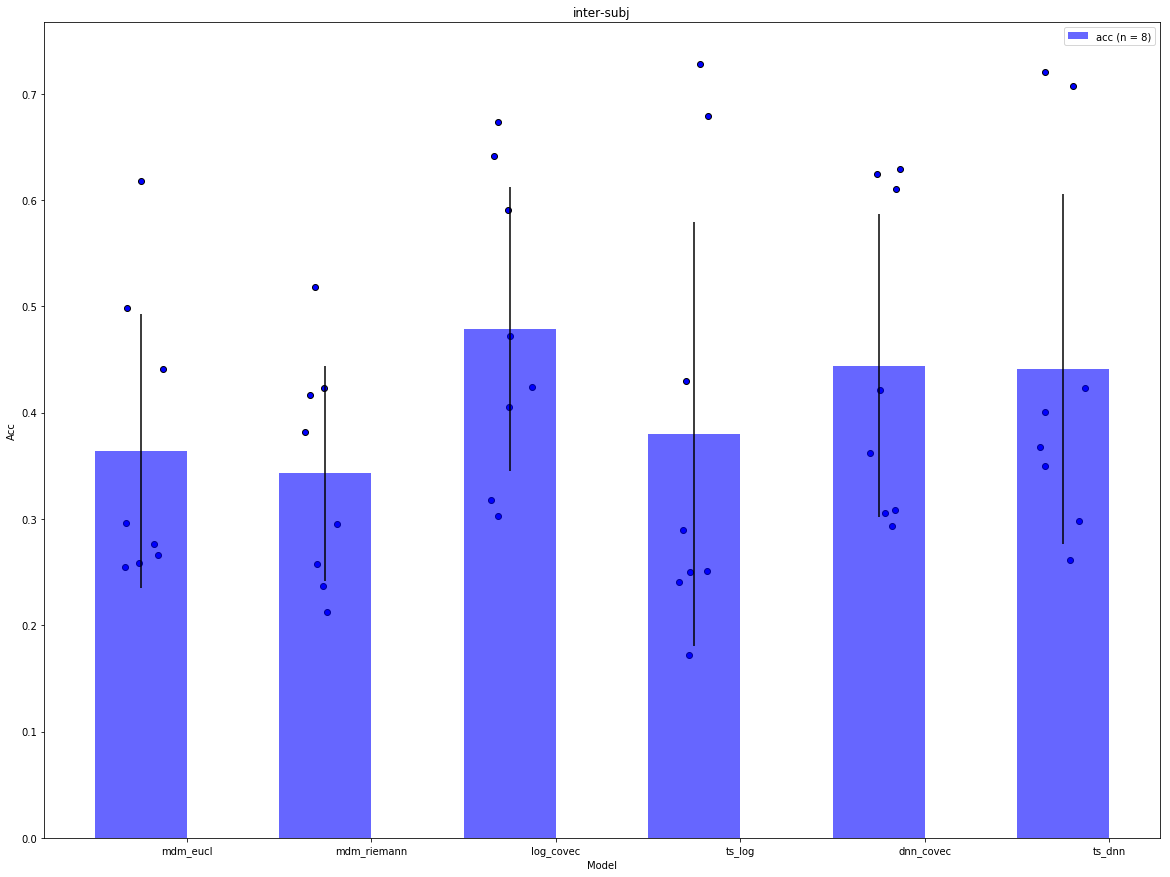

In [94]:
viz.bar_plot_scatter_comp([acc_subj], model_labels, 'inter-subj', ['acc'])

In [95]:
b = time.time()
print(b - a)

655.5352771282196
